<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Построение модели предсказывающей отток клиентов «Бета-Банка»

# Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. По данным банковских маркетологов сохранять текущих клиентов дешевле, чем привлекать новых. В нашем рпаспоряжении исторические данные о поведении клиентов и расторжении договоров с банком. 

# Цель проекта

Построить модель, способную прогнозировать, уйдёт клиент из банка в ближайшее время или нет.

# Ход выполнения проекта

- Шаг 1. Откроем файл с данными и изучим общую информацию
    - путь к файлу: /datasets/Churn.csv;
    - изучим общую информацию;
    - подготовим данные к обработке;
    - напишем вывод по шагу 1.
- Шаг 2. Исследуем данные
    - исследуем баланс классов, построим модель с предельно большим значением *F1*-меры (метрика должна быть не менее 0.59);
    - обучим модель без учёта дисбаланса;
    - измерим *AUC-ROC*, сравним её значение с *F1*-мерой;
    - напишем вывод по шагу 2.
- Шаг 3. Избавимся от дисбаланса данных
    - улучшитм качество модели, учитывая дисбаланс классов;
    - обучим разные модели и найдем лучшую;
    - напишем вывод по шагу 3.
- Шаг 4. Протестируем модель
    - проведем финальное тестирование лучшей модели на тестовой выборке;
    - проверим *F1*-меру на тестовой выборке (метрика должна быть не менее 0.59);
    - напишем вывод по шагу 4.
- Шаг 5. Напишем общий вывод по проекту и дадим реккомендации
    - Напишем общий вывод по проекту.
    

# Дополнительная информация

**Описание данных**

Признаки

    RowNumber — индекс строки в данных
    CustomerId — уникальный идентификатор клиента
    Surname — фамилия
    CreditScore — кредитный рейтинг
    Geography — страна проживания
    Gender — пол
    Age — возраст
    Tenure — сколько лет человек является клиентом банка
    Balance — баланс на счёте
    NumOfProducts — количество продуктов банка, используемых клиентом
    HasCrCard — наличие кредитной карты
    IsActiveMember — активность клиента
    EstimatedSalary — предполагаемая зарплата
   **Целевой признак**
        Exited — факт ухода клиента

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
! pip install missingno
import missingno as msno

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, roc_curve

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [3]:
try:
    try:
        df = pd.read_csv('datasets\Churn.csv') #локальная версия
    except:
        df = pd.read_csv('/datasets/Churn.csv') #сетевая версия
except:
    print('Не удалось прочесть файл. Возможно, был указан не верный путь.')

In [4]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [5]:
#посмотрим общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


<AxesSubplot:>

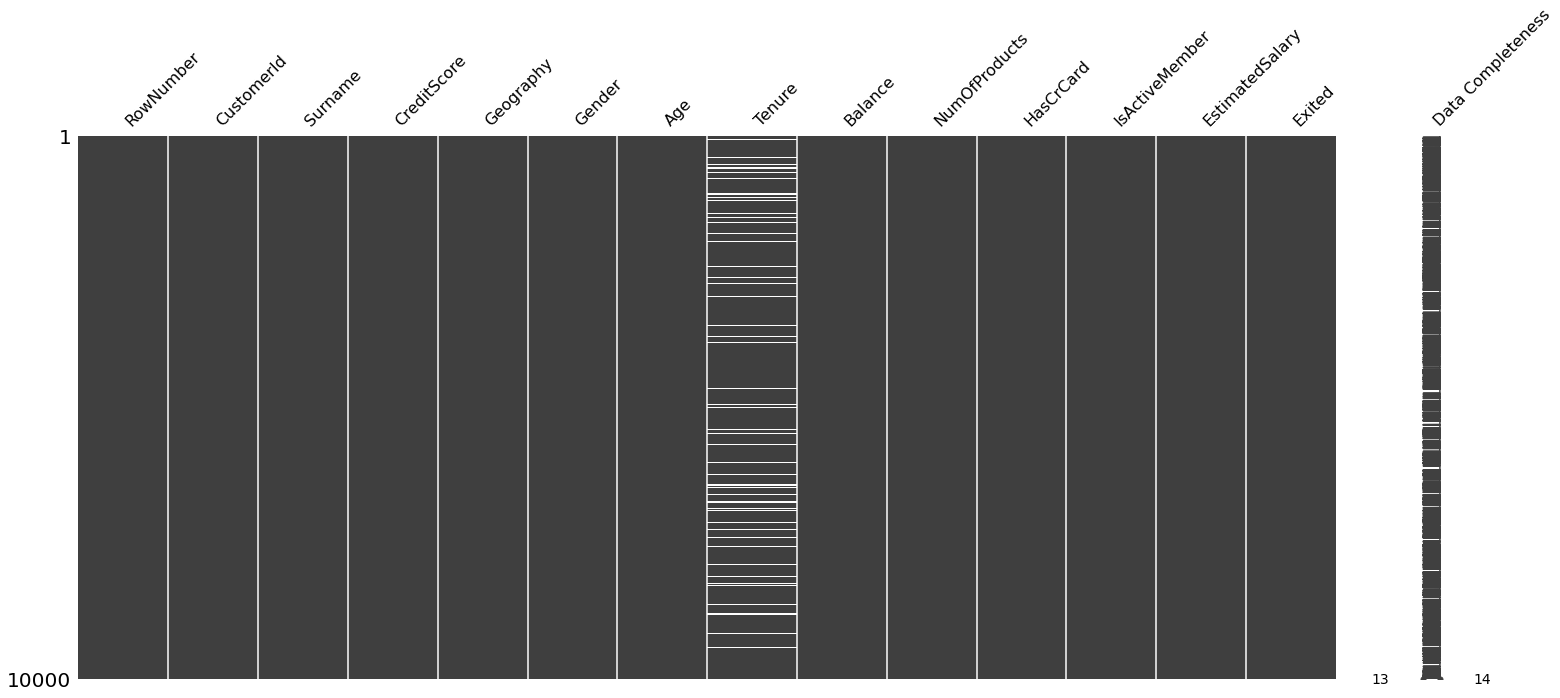

In [6]:
#визуализируем целостность набора данных, для дальнейшей их обработки
msno.matrix(df, labels=True)

**В датафрейме лишь один столбец Tenure (сколько лет человек является клиентом банка) имеет до 1000 пропусков.**

<AxesSubplot:>

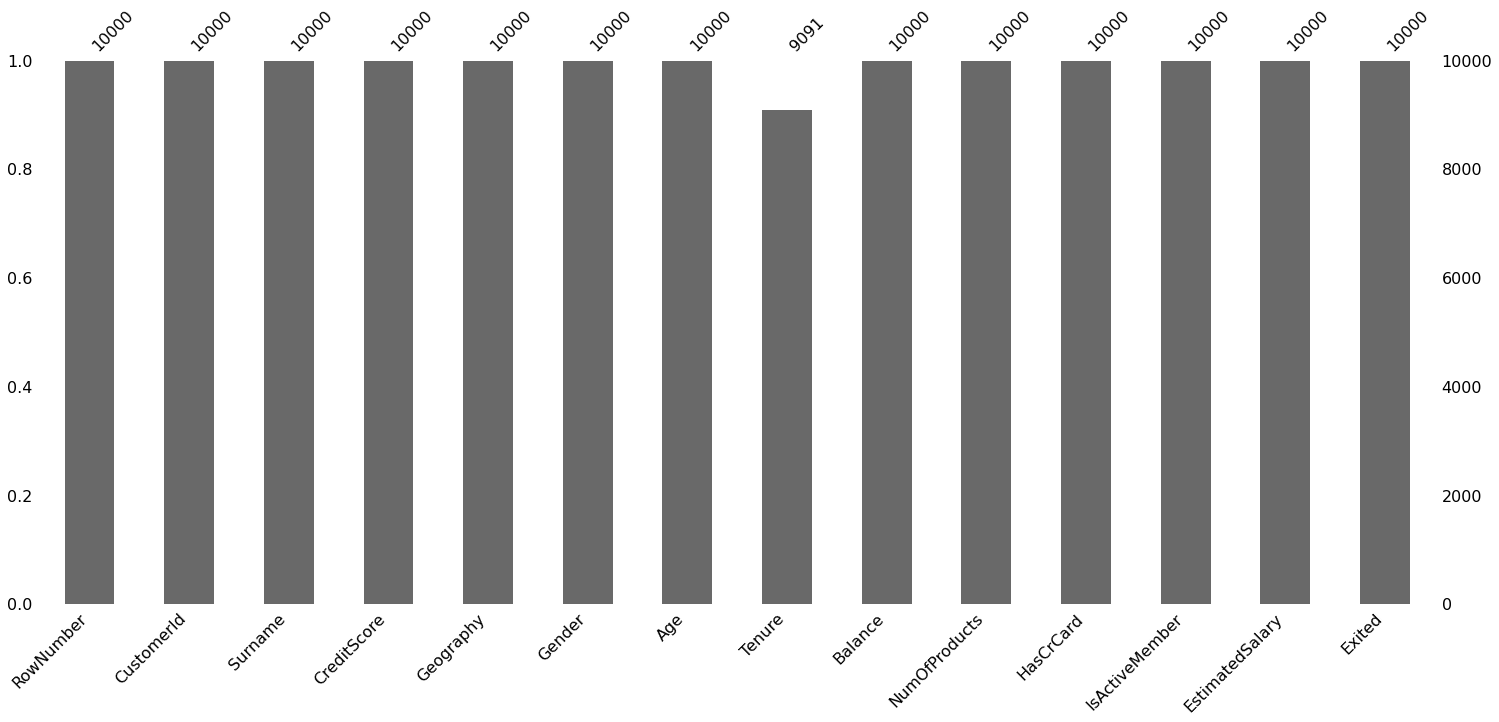

In [7]:
#визуализируем пропущенные столбцы с пропусками
msno.bar(df, labels=True)

In [8]:
print(f'Размерность датафрейма до удаления дубликатов, столбцов (строк и столбцов соответственно):', df.shape)
print()

Размерность датафрейма до удаления дубликатов, столбцов (строк и столбцов соответственно): (10000, 14)



In [ ]:
#Обработаем пропуски.
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())

In [10]:
df.isnull().sum() #пропущенных значений больше нет

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [11]:
#Удалим лишние столбцы, которые не пригодятся нам в исследовании
df.drop(['RowNumber','CustomerId','Surname'], axis=1, inplace=True) #RowNumber — индекс строки в данных
                                                                    #CustomerId — уникальный идентификатор клиента
                                                                    #Surname — фамилия
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [12]:
#проверим количество явных дубликатов
df.duplicated().sum()

0

In [13]:
#Преобразуем данные в нужные типы, при необходимости 
df['Tenure'] = df['Tenure'].astype(int) #столбик Tenure - сколько лет человек является клиентом банка имеет целочисленные значения

In [14]:
# Заменим названия столбцов (приведем их к нижнему регистру);
def camel_to_snake(column):
    for char in column:
        if char.isupper():
            column = column.replace(char, '_' + char.lower())
    return column[1:]

In [15]:
for col in df.columns:
    new_col = camel_to_snake(col)
    df.rename(columns = {col : new_col}, inplace=True)
print(df.columns)

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')


In [16]:
#посмотрим на уникальные значения столбцов
print(sorted(df['credit_score'].unique()))
print(sorted(df['geography'].unique()))
print(sorted(df['gender'].unique()))
print(sorted(df['age'].unique()))
print(sorted(df['tenure'].unique()))
print(sorted(df['num_of_products'].unique()))
print(sorted(df['has_cr_card'].unique()))
print(sorted(df['is_active_member'].unique()))
print(sorted(df['exited'].unique()))

[350, 351, 358, 359, 363, 365, 367, 373, 376, 382, 383, 386, 395, 399, 401, 404, 405, 407, 408, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590,

In [18]:
df.describe() #рассчитаем метрики для столбцов с числовыми значениями

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.99790,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.76001,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.00000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.00000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.00000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.00000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.00000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [19]:
#подготовим категориальные данные и избежим дамми-ловушки
categorical_columns = ['geography', 'gender']
df = pd.get_dummies(df, columns=['geography', 'gender'], drop_first=True)
df

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,0,1


**Некоторые из столбцов требуют масштабирования: 'credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary'**

In [20]:
print(f'Размерность датафрейма после предобработки:', df.shape)
print()

Размерность датафрейма после предобработки: (10000, 12)



In [21]:
#Разобьем данные на три выборки (обучающую, валидационную и тестовую выборки).
#Выделим в отдельные переменные фичи и целевой признак
target = df['exited']
features = df.drop(['exited'], axis=1)

In [22]:
#Разделим данные на обучающую(60%), валидационную(20%) и тестовую выборки(20%)
features_train_val, features_test, target_train_val, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_val, target_train_val, test_size=0.25, random_state=12345)

#Провреим размер каждой выборки
print('Размер обучающей выборки:', features_train.shape[0])
print('Размер валидационной выборки:', features_valid.shape[0])
print('Размер тестовой выборки:', features_test.shape[0])

Размер обучающей выборки: 6000
Размер валидационной выборки: 2000
Размер тестовой выборки: 2000


In [23]:
#Провреим размер каждой выборки
print('Размер обучающей выборки:', features_train.shape)
print('Размер валидационной выборки:', features_valid.shape)
print('Размер тестовой выборки:', features_test.shape)

Размер обучающей выборки: (6000, 11)
Размер валидационной выборки: (2000, 11)
Размер тестовой выборки: (2000, 11)


In [24]:
#масштабируем признаки
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

scaler = StandardScaler() #создааем объект
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
print(features_test.head())

      credit_score       age    tenure   balance  num_of_products  \
7867     -0.123733  0.685430 -0.730812 -1.232442        -0.896909   
1402      1.083087 -0.937002  1.077681  0.858518        -0.896909   
8606      1.598822  0.303681 -0.007415 -1.232442         0.816929   
8885      0.165078  0.589993 -0.369113  0.412100         0.816929   
6494      0.484834 -1.032439  0.715982 -1.232442         0.816929   

      has_cr_card  is_active_member  estimated_salary  geography_Germany  \
7867            1                 1          0.980212                  0   
1402            1                 0         -0.390486                  0   
8606            1                 1         -0.435169                  0   
8885            1                 1          1.017079                  0   
6494            1                 1         -1.343558                  0   

      geography_Spain  gender_Male  
7867                1            0  
1402                0            1  
8606             

/tmp/ipykernel_186/2381332449.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_186/2381332449.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

**Вывод по шагу 1:**

Мы изучили общую информацию о данных, удалили лишние для исследования столбцы: RowNumber — индекс строки в данных, CustomerId — уникальный идентификатор клиента, Surname — фамилия. Также в столбце Tenure (сколько лет человек является клиентом банка) было замечено 909 пропусков, строки с которыми нами заменены медианными значениями. Несколько категориальных признаков было закодировано в числовом виде для обучения модели.

Датафрейм для удобства обучения и тестирования разделен на 3 выборки:  
   - размер обучающей выборки: 6000 строк;
   - размер валидационной выборки: 2000 строк;
   - размер тестовой выборки: 2000 строк.

Некоторые столбцы были отмасштабированы: 'credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary', чтобы исключить влияние больших значений при обучении моделей на конечный результат.

Все данные готовы для дальнейшего исследования.

## Исследование задачи

Нам требуется предсказать уход клиента из банка в ближайшее время. Бинарный исход задачи (да/нет) позволяет использовать три популярные для решения такого типа задач модели:
 - логистическая регрессия;
 - дерево решений;
 - случайный лес.

Построим каждую из этих моделей и выберем лучшую, с учетом подобранных гиперпараметров. Исследуем баланс классов на обучающей выборке.

In [26]:
%%time

#построим модель логистической регрессии
best_f1 = 0
for verb in tqdm(range(1, 10, 1)):
    for iter in range(1, 10, 1):
        model = LogisticRegression(max_iter=iter, verbose=verb, solver='liblinear', random_state=12345) #создаем объект модели
        model.fit(features_train, target_train) #обучаем модель
        prediction_valid = model.predict(features_valid) 
        
#комментарий студента v1 
        probabilities_valid = model.predict_proba(features_valid)#предскажем вероятность целевого признака на валид. фичах
        probabilities_one_valid = probabilities_valid[:, 1]#выделим массив предсказанных вероятностей класса 1

        f1_valid = f1_score(target_valid, prediction_valid) #оцениваем f1-метрику для модели на валидационной выборке
        if f1_valid > best_f1:
            best_f1 = f1_valid #зафиксируем значение лучшей f1-метрики
            best_iter = iter #зафиксируем значение гиперпараметра
            best_verbose = verb #зафиксируем значение гиперпараметра
            best_prediction_valid = prediction_valid #сохраним предсказанный целевой признак модели с лучшими гиперпараметрами
        
print(f'Максимальная оценка качества модели (f1-метрика): {round(best_f1, 5)}, при {best_iter} итерациях.')
print('Плотность: {:.3f} | Точность: {:.3f} | ROC_AUC: {:.3f}'.format(recall_score(target_valid, best_prediction_valid),
                                                                      precision_score(target_valid, best_prediction_valid),
                                                                      roc_auc_score(target_valid, probabilities_one_valid)))

  0%|          | 0/9 [00:00<?, ?it/s]

[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4
[LibLinear]

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4
[LibLinear]iter  1 act 1.435e+03 pre 1.307e

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
[LibLinear]

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4
[LibLinear]

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e+02 delta 1.081e+00 f 2.724e+03 |g| 5.057e+02 CG   4
iter  3 act 1.343e+01 pre 1.273e+01 delta 1.081e+00 f 2.567e+03 |g| 1.188e+02 CG   6
iter  4 act 1.318e-01 pre 1.310e-01 delta 1.081e+00 f 2.554e+03 |g| 1.170e+01 CG   6
iter  5 act 6.175e-05 pre 6.174e-05 delta 1.081e+00 f 2.554e+03 |g| 2.544e-01 CG   4
[LibLinear]iter  1 act 1.435e+03 pre 1.307e+03 delta 1.081e+00 f 4.159e+03 |g| 2.853e+03 CG   2
iter  2 act 1.564e+02 pre 1.380e

In [28]:
%%time

#построим модель дерева решений

best_depth_ = 0
best_f1 = 0
for depth in range(1, 21, 2):
    for smsp in range(2, 10, 1):
        #создаем модель решающего дерева с гиперпараметрами
        model = DecisionTreeClassifier(max_depth=depth, min_samples_split=smsp,random_state=12345)
        model.fit(features_train, target_train) #обучаем модель
        prediction_valid = model.predict(features_valid) #делаем предсказания на валидационной выборке

        probabilities_valid = model.predict_proba(features_valid)#предскажем вероятность целевого признака на валид. фичах
        probabilities_one_valid = probabilities_valid[:, 1]#выделим массив предсказанных вероятностей класса 1

        f1_valid = f1_score(target_valid, prediction_valid) #оцениваем f1-метрику для модели на валидационной выборке
        if f1_valid > best_f1:
            best_f1 = f1_valid
            best_depth_ = depth
            best_smsp = smsp
            best_prediction_valid = prediction_valid
        

print(f'Максимальная оценка качества модели (f1-метрика): {round(best_f1, 5)}, при глубине дерева - {best_depth_}.')
print('Плотность: {:.3f} | Точность: {:.3f} | ROC_AUC: {:.3f}'.format(recall_score(target_valid, best_prediction_valid),
                                                                      precision_score(target_valid, best_prediction_valid),
                                                                      roc_auc_score(target_valid, probabilities_one_valid)))

Максимальная оценка качества модели (f1-метрика): 0.55836, при глубине дерева - 7.
Плотность: 0.453 | Точность: 0.728 | ROC_AUC: 0.724
CPU times: user 2.03 s, sys: 56 ms, total: 2.08 s
Wall time: 2.08 s


In [29]:
%%time

#построим модель случайного леса
best_f1 = 0
for est in tqdm(range(10, 111, 5)):
    for depth in range (1, 18):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        prediction_valid = model.predict(features_valid)
        
        probabilities_valid = model.predict_proba(features_valid)#предскажем вероятность целевого признака на валид. фичах
        probabilities_one_valid = probabilities_valid[:, 1]#выделим массив предсказанных вероятностей класса 1       
        
        f1_valid = f1_score(target_valid, prediction_valid)
        if f1_valid > best_f1:
            best_f1 = f1_valid
            best_prediction_valid = prediction_valid
            best_est = est
            best_depth = depth

print(f'Максимальная оценка качества модели (f1-метрика): {round(best_f1, 5)}, при количестве деревьев {best_est} \
\nи глубине - {best_depth}.')
print('Плотность: {:.3f} | Точность: {:.3f} | ROC_AUC: {:.3f}'.format(recall_score(target_valid, best_prediction_valid),
                                                                      precision_score(target_valid, best_prediction_valid),
#                                                                     roc_auc_score(target_valid, best_prediction_valid)))
                                                                      roc_auc_score(target_valid, probabilities_one_valid)))

  0%|          | 0/21 [00:00<?, ?it/s]

Максимальная оценка качества модели (f1-метрика): 0.58054, при количестве деревьев 40 
и глубине - 14.
Плотность: 0.465 | Точность: 0.771 | ROC_AUC: 0.844
CPU times: user 2min 12s, sys: 908 ms, total: 2min 13s
Wall time: 2min 13s


<div class="alert-info"><b>Вывод по шагу 2:</b>
    
    Из 3 моделей лучше всего себя показала модель случайного леса с числом деревьев - 40 и глубиной - 14. Её показатель качества при дисбалансе классов - 0.58054.
    
    В нашем случае, F1-метрика составляет 0.58054, а ROC-AUC равен 0,844. Это означает, что модель имеет достаточно высокую точность и полноту, а также хорошую способность отличать между собой классы. Попробуем избавиться от дисбаланса классов далее.</div>

## Борьба с дисбалансом

In [30]:
%%time
#улучшим качество модели, учитывая дисбаланс классов, изменим их вес.
#построим модель случайного леса c гиперпараметром class_weight='balanced'
model = RandomForestClassifier(n_estimators=best_est, max_depth=best_depth, random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
prediction_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)#предскажем вероятность целевого признака на валид. фичах
probabilities_one_valid = probabilities_valid[:, 1]#выделим массив предсказанных вероятностей класса 1       

f1_valid = f1_score(target_valid, prediction_valid)

print(f'Максимальная оценка качества модели (f1-метрика): {round(f1_valid, 5)}, при количестве деревьев {best_est}\
\nи глубине - {best_depth}.')
print('Плотность: {:.3f} | Точность: {:.3f} | ROC_AUC: {:.3f}'.format(recall_score(target_valid, best_prediction_valid),
                                                                      precision_score(target_valid, best_prediction_valid),
                                                                      roc_auc_score(target_valid, probabilities_one_valid)))

Максимальная оценка качества модели (f1-метрика): 0.56372, при количестве деревьев 40
и глубине - 14.
Плотность: 0.465 | Точность: 0.771 | ROC_AUC: 0.842
CPU times: user 335 ms, sys: 82 µs, total: 335 ms
Wall time: 347 ms


Наивысший показатель F1 = 0.588, при смещении порога до значения 0.29


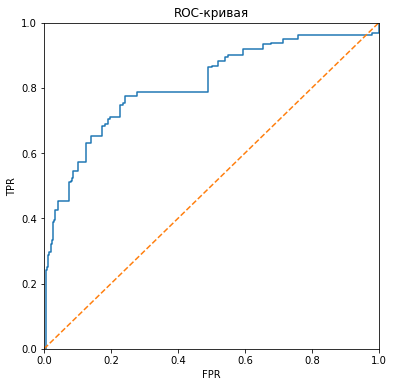

In [31]:
#изменим порог классификации
model = DecisionTreeClassifier(max_depth=best_depth_, random_state=1234)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

best_f1 = 0
for threshold in thresholds:
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    if best_f1 < f1:
        best_f1 = f1
        best_threshold = threshold

print("Наивысший показатель F1 = {:.3f}, при смещении порога до значения {:.2f}".format(best_f1, best_threshold))
plt.figure(figsize = (6, 6))
plt.step(fpr, tpr, where='post')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show();

In [32]:
#Увеличим выборку, upsampling
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

#features_upsampled, target_upsampled = upsample(features_train, target_train,3)
features_upsampled, target_upsampled = upsample(features_train, target_train,4)


best_f1 = 0
for est in tqdm(range(10, 111, 5)):
    for depth in range (1, 18):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_upsampled, target_upsampled)
        prediction_valid = model.predict(features_valid)
        
        probabilities_valid = model.predict_proba(features_valid)#предскажем вероятность целевого признака на валид. фичах
        probabilities_one_valid = probabilities_valid[:, 1]#выделим массив предсказанных вероятностей класса 1         
        
        f1_valid = f1_score(target_valid, prediction_valid)
        if f1_valid > best_f1:
            best_f1 = f1_valid
            best_prediction_valid = prediction_valid
            best_est = est
            best_depth = depth
            prod_model = model

print(f'Максимальная оценка качества модели (f1-метрика): {round(best_f1, 5)}, при количестве деревьев {best_est}\
\nи глубине - {best_depth}.')
print('Плотность: {:.3f} | Точность: {:.3f} | ROC_AUC: {:.3f}'.format(recall_score(target_valid, best_prediction_valid),
                                                                      precision_score(target_valid, best_prediction_valid),
                                                                      roc_auc_score(target_valid, probabilities_one_valid)))

  0%|          | 0/21 [00:00<?, ?it/s]

Максимальная оценка качества модели (f1-метрика): 0.60834, при количестве деревьев 90
и глубине - 16.
Плотность: 0.578 | Точность: 0.642 | ROC_AUC: 0.847


In [33]:
#уменьшаем выборку, downsampling

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled


features_downsampled, target_downsampled = downsample(features_train, target_train, 0.2)


best_f1 = 0
for est in tqdm(range(10, 111, 5)):
    for depth in range (1, 18):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_downsampled, target_downsampled)
        prediction_valid = model.predict(features_valid)
        
        probabilities_valid = model.predict_proba(features_valid)#предскажем вероятность целевого признака на валид. фичах
        probabilities_one_valid = probabilities_valid[:, 1]#выделим массив предсказанных вероятностей класса 1    
        
        f1_valid = f1_score(target_valid, prediction_valid)
        if f1_valid > best_f1:
            best_f1 = f1_valid
            best_prediction_valid = prediction_valid
            best_est = est
            best_depth = depth

print(f'Максимальная оценка качества модели (f1-метрика): {round(best_f1, 5)}, при количестве деревьев {best_est}\
\nи глубине - {best_depth}.')
print('Плотность: {:.3f} | Точность: {:.3f} | ROC_AUC: {:.3f}'.format(recall_score(target_valid, best_prediction_valid),
                                                                      precision_score(target_valid, best_prediction_valid),
                                                                      roc_auc_score(target_valid, probabilities_one_valid)))

  0%|          | 0/21 [00:00<?, ?it/s]

Максимальная оценка качества модели (f1-метрика): 0.5533, при количестве деревьев 110
и глубине - 9.
Плотность: 0.803 | Точность: 0.422 | ROC_AUC: 0.839


<div class="alert-info"><b>Вывод по шагу 3:</b>

Из 4 методов борьбы с дисбалансом лучше всего себя показал upsampling, т.е. увеличение выборки. Максимальная оценка качества модели леса решений (f1-метрика): 0.60834, при количестве деревьев 90 и глубине - 16 на валидационной выборке. ROC_AUC: 0.847, что говорит о том, что модель имеет достаточно высокую точность и полноту, а также хорошую способность отличать между собой классы. </div>

## Тестирование модели

In [ ]:
#проверим F1-меру на тестовой выборке (метрика должна быть не менее 0.59);
model_forest_pred_test = prod_model.predict(features_test)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]


f1_test = f1_score(target_test, model_forest_pred_test)
print(f'Оценка f1 метрики у лучшей модели {f1_test}')

print(f'ROC_AUC: {roc_auc_score(target_test, probabilities_one_test)}')

Оценка f1 метрики у лучшей модели 0.6091370558375634
ROC_AUC: 0.849091296185186


<div class="alert-info"><b>Вывод по шагу 4</b>

F1-мера более 0.59, что было одним из условий в проекте. Максимальная оценка качества модели леса решений (f1-метрика): 0.609, при количестве деревьев 90 и глубине - 16 на тестовой выборке. ROC_AUC: 0.849, модель достаточно хорошо отличает классы.</div>

<div class="alert-info"><b>Общий вывод по проекту:</b>

Мы изучили общую информацию о данных, удалили лишние для исследования столбцы: индекс строки в данных, уникальный идентификатор клиента, фамилия. Также в столбце Tenure (сколько лет человек является клиентом банка) было замечено 909 пропусков, строки с которыми нами заменены на медианные значения.Разработчикам стоит проверить как происходит сбор данных о клиентах у которых замечены пропуски и более детально разобраться в причинах их возникновения. Несколько категориальных признаков было закодировано в числовом виде для обучения модели.

Датафрейм разделен на 3 выборки:
- размер обучающей выборки: 6000 строк;
- размер валидационной выборки: 2000 строк;
- размер тестовой выборки: 2000 строк.

Из 3 исследованных моделей на валидационной выборке лучше всего себя показала модель случайного леса при дисбалансе классов F1-мера - 0.58054. 

Из 4 методов борьбы с дисбалансом лучше всего себя показал upsampling, т.е. увеличение выборки. Максимальная оценка качества модели леса решений (f1-метрика): 0.60834; ROC_AUC: 0.847, что говорит говорит о том, что модель имеет достаточно высокую точность и полноту, а также хорошую способность отличать между собой классы. 

F1-мера более 0.59, что было одним из условий в проекте. Максимальная оценка качества модели леса решений (f1-метрика) на тестовой выборке: 0.609, при количестве деревьев 90 и глубине - 16. ROC_AUC: 0.849, модель достаточно хорошо отличает классы. 

<b>Таким образом нам удалось построить модель, способную прогнозировать, уйдёт клиент из банка в ближайшее время или нет с достаточно хорошим процентом точности классификации клиентов.</b>
</div>

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*